In [24]:
import pandas as pd
import numpy as np
import os
import joblib
from keras.src.layers import TextVectorization, LayerNormalization, GlobalAveragePooling1D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from joblib import parallel_backend
import seaborn as sns
import tensorflow as tf
from tensorflow.python.keras.layers import GlobalMaxPooling1D

In [ ]:
%%sql


In [25]:
# load in the data 

promoters = pd.read_csv('Data/promoter.csv')
promoters.columns = ['Sequence']
non_promoters = pd.read_csv('Data/non_promoter.csv')
non_promoters.columns = ['Sequence']
# clip all the sequences to the same length
label_vector = np.ones(promoters.shape[0]).tolist() + np.zeros(non_promoters.shape[0]).tolist()
combined_data = pd.concat([promoters, non_promoters], axis=0)
# find minimum length
min_len = min(combined_data['Sequence'].str.len())
combined_data['Sequence'] = combined_data['Sequence'].str.slice(0, min_len)

In [26]:
# train test validation split
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    combined_data, label_vector, test_size=0.2, stratify=label_vector, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, stratify=y_train_val, random_state=42
)  # 0.125 because 0.125 * 80% = 10%

# Check the sizes
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 42000
Validation size: 6000
Test size: 12000


In [37]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.cluster import KMeans

class KmerVectorizer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to vectorize k-mers for different K values.
    """
    def __init__(self, K=3):
        self.K = K
        self.vectorizer = None

    def fit(self, X, y=None):
        self.vectorizer = CountVectorizer(analyzer='char', ngram_range=(self.K, self.K))
        self.vectorizer.fit(X)
        return self

    def transform(self, X):
        return self.vectorizer.transform(X)


def evaluate_model(best_model, X_test, y_test, model_name, attention=False, max_length=None, tokenizer=None):
    """
    Evaluate a model on the test set and generate metrics including ROC curves.

    Parameters:
    - best_model: The trained model to evaluate.
    - X_test: Test data (features).
    - y_test: Test labels.
    - model_name: Name of the model for saving results.

    Returns:
    - metrics: Dictionary of evaluation metrics.
    """
    print(f"Evaluating {model_name} on test data...")

    # Check if model is a Keras model
    if isinstance(best_model, tf.keras.Model):
        # Convert X_test to a tf.Tensor with dtype=tf.string
        if not attention:
            X_test_tensor = tf.constant(X_test, dtype=tf.string)
        else:
            X_test_tokenized = tokenize_and_pad_kmers(X_test, tokenizer, k=5, max_length=max_length)
            X_test_tensor = tf.constant(X_test_tokenized, dtype=tf.int32)
        # Get predicted probabilities
        y_prob = best_model.predict(X_test_tensor).flatten()
        y_prob = y_prob.astype(np.float64)
        # normalize between 0 and 1
    else:
        # For scikit-learn models
        if hasattr(best_model, "predict_proba"):
            y_prob = best_model.predict_proba(X_test)[:, 1]
        else:
            y_prob = best_model.predict(X_test)

    # Convert y_test and y_prob to NumPy arrays if they aren't already
    y_test = np.array(y_test)  # Ensure y_test is a NumPy array
    y_prob = np.array(y_prob)  # Ensure y_prob is a NumPy array

    y_pred = (y_prob > 0.5).astype(int)

    # Compute metrics with the best threshold
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
    }

    # Print results
    print(f"Results for {model_name}:")
    print(f"Accuracy: {metrics['accuracy']:.2f}")
    print(f"Precision: {metrics['precision']:.2f}")
    print(f"Recall: {metrics['recall']:.2f}")
    print(f"F1 Score: {metrics['f1']:.2f}")

    # Save the metrics
    results = pd.DataFrame(metrics, index=[0])
    results.to_csv(f'{model_name}_metrics.csv', index=False)

    # Visualize distribution of probabilities
    print(np.unique(y_test, return_counts=True))
    print(np.unique(y_pred, return_counts=True))
    plt.hist(y_prob, bins=50)
    plt.title("Distribution of Predicted Probabilities")
    plt.show()

    # Generate ROC curve if probabilities are available
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        metrics['roc_auc'] = roc_auc

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f"ROC Curve for {model_name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.savefig(f"{model_name}_roc_curve.png")
        plt.show()
        print(f"ROC curve saved as '{model_name}_roc_curve.png'")
    else:
        print("Predicted probabilities are not available; ROC curve cannot be generated.")

    print(f"Metrics for {model_name} saved as '{model_name}_metrics.csv'")
    return metrics, y_pred, y_prob




def gridsearch_with_logging(X_train, y_train, model, param_grid, model_name, cv=5, scoring='accuracy', max_cpu_fraction=0.7, transform=True):
    """
    Perform grid search with cross-validation, tracking progress and logging results, while limiting resource usage.

    Parameters:
    - X_train: Training data (features).
    - y_train: Training labels.
    - model: sklearn model.
    - param_grid: Parameter grid for grid search.
    - model_name: Name of the model for saving/loading files.
    - cv: Number of cross-validation folds.
    - scoring: Scoring metric.
    - max_cpu_fraction: Fraction of available CPU resources to use.

    Returns:
    - best_model: Trained pipeline with the best parameters.
    - best_params: Best parameter set.
    - best_score: Best cross-validation score.
    """
    # Check if the model is already trained
    model_file = f'best_{model_name}_model.pkl'
    log_file = f'{model_name}_gridsearch_log.csv'

    if os.path.exists(model_file):
        print(f"Model '{model_file}' already exists. Loading the model...")
        best_model = joblib.load(model_file)
        return best_model, None, None

    # Create pipeline
    if transform:
        pipeline = Pipeline([
            ('kmer', KmerVectorizer()),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([
            ('model', model)
        ])
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1,# Will be controlled by `parallel_backend`
        verbose= 4
    )

    # Custom callback for progress tracking
    current_combination = 0

    # Start grid search with resource constraints
    print(f"Starting grid search for {model_name} with up to {max_cpu_fraction * 100:.0f}% CPU usage...")

    with parallel_backend('loky', n_jobs=int(max_cpu_fraction * os.cpu_count())):
        grid_search.fit(X_train, y_train)

        # Save log
    results = pd.DataFrame(grid_search.cv_results_)
    results.to_csv(log_file, index=False)

    # Get the best model and save it
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, model_file)
    print(f"Best model saved as '{model_file}'")

    return best_model, grid_search.best_params_, grid_search.best_score_



0 0
1 0
2 0
0 1
1 1
2 1


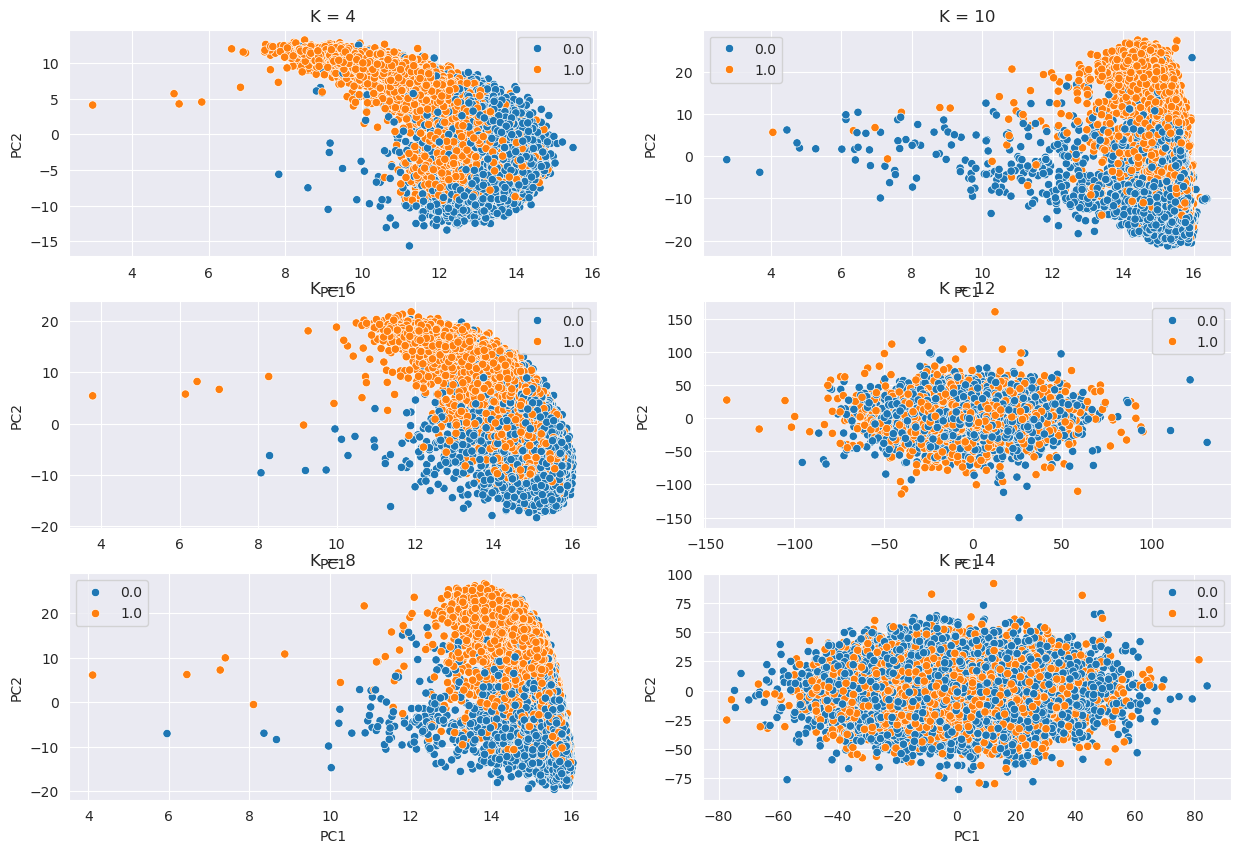

In [12]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
for i, K in enumerate([4, 6, 8, 10, 12, 14]):
    # Create pipeline
    svd_pipeline = Pipeline([
        ('kmer', KmerVectorizer(K=K)),
        ('scaler', StandardScaler(with_mean=False)),
        ('pca', TruncatedSVD(n_components=2))
    ])

    # Fit and transform the data
    X_pca = svd_pipeline.fit_transform(X_train['Sequence'].values)
    X_svd = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    X_svd['Promoter'] = y_train

    # Plot the data
    j = i // 3
    i = i % 3
    print(i, j)
    sns.scatterplot(data=X_svd, x='PC1', y='PC2', hue='Promoter', ax=ax[i, j])
    ax[i, j].set_title(f"K = {K}")
    ax[i, j].legend()


In [263]:
# training Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
print(f"X_train shape: {len(X_train)}")
print(f"y_train shape: {len(y_train)}")
# why multionomialNB?
nb_model = MultinomialNB()
nb_param_grid = {
    'kmer__K': [4, 6, 8, 10],
    'model__alpha': [0.1, 0.5, 1.0],
}
best_nb_model, best_nb_params, best_nb_score = gridsearch_with_logging(
    X_train['Sequence'].values, y_train, nb_model, nb_param_grid, 'naive_bayes'
)
# displaying the best parameters and score
print("Best Parameters:", best_nb_params)


X_train shape: 42000
y_train shape: 42000
Starting grid search for naive_bayes with up to 70% CPU usage...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best model saved as 'best_naive_bayes_model.pkl'
Best Parameters: {'kmer__K': 10, 'model__alpha': 0.1}


{'kmer__K': 10, 'model__alpha': 0.1}
Evaluating naive_bayes on test data...
Results for naive_bayes:
Accuracy: 0.84
Precision: 0.89
Recall: 0.78
F1 Score: 0.83
(array([0., 1.]), array([6000, 6000]))
(array([0, 1]), array([6698, 5302]))


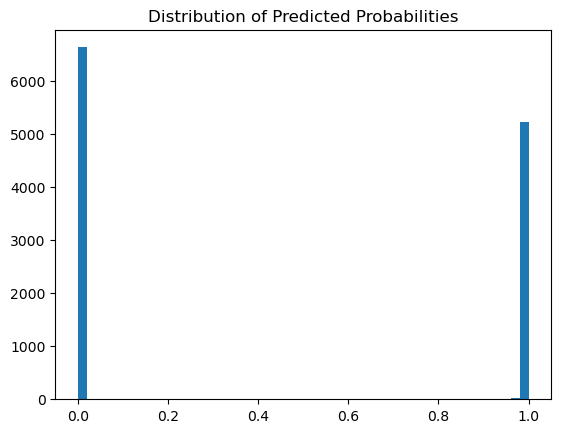

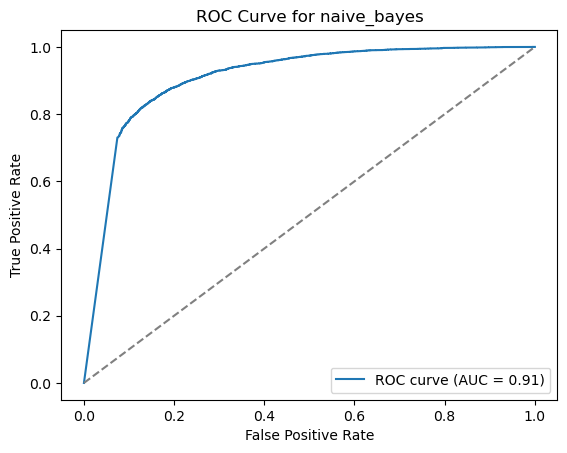

ROC curve saved as 'naive_bayes_roc_curve.png'
Metrics for naive_bayes saved as 'naive_bayes_metrics.csv'
({'accuracy': 0.841, 'precision': 0.8858921161825726, 'recall': 0.7828333333333334, 'f1': 0.8311803220668909, 'roc_auc': 0.9080783611111112}, array([1, 0, 1, ..., 0, 1, 0]), array([1.00000000e+000, 1.26134449e-055, 1.00000000e+000, ...,
       4.25293499e-106, 1.00000000e+000, 3.93259258e-148]))


In [264]:
# evaluating the model
print(best_nb_params)
nb_metrics = evaluate_model(best_nb_model, X_test['Sequence'].values, y_test, 'naive_bayes')
print(nb_metrics)

In [265]:
# training Random Forest model
# Define the Random Forest model and parameter grid
model = RandomForestClassifier(random_state=42)
param_grid = {
    'kmer__K': [4, 6, 8, 10,],  # Different k-mer sizes
    'model__n_estimators': [50, 100, 200],  # Number of trees
    'model__max_depth': [10, 20, 50, 100],  # Maximum depth of the trees
    'model__min_samples_split': [2],  # Minimum samples required to split an internal node
}

# Perform grid search with logging
best_rf_model, best_rf_params, best_rf_score = gridsearch_with_logging(
    X_train=X_train['Sequence'].values,
    y_train=y_train,
    model=model,
    param_grid=param_grid,
    model_name='random_forest',
    cv=5,
    scoring='accuracy'
)

Starting grid search for random_forest with up to 70% CPU usage...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 3/5] END kmer__K=6, model__alpha=0.5;, score=(train=0.794, test=0.786) total time=   9.2s
[CV 4/5] END kmer__K=6, model__max_depth=20, model__min_samples_split=2, model__n_estimators=200;, score=(train=0.906, test=0.851) total time=44.7min
[CV 2/5] END kmer__K=6, model__alpha=0.1;, score=(train=0.793, test=0.790) total time=   9.4s
[CV 1/5] END kmer__K=6, model__max_depth=20, model__min_samples_split=2, model__n_estimators=200;, score=(train=0.906, test=0.851) total time=44.3min
[CV 4/5] END kmer__K=10, model__alpha=0.5;, score=(train=0.931, test=0.831) total time=  28.0s
[CV 2/5] END kmer__K=8, model__max_depth=10, model__min_samples_split=2, model__n_estimators=50;, score=(train=0.770, test=0.758) total time= 5.1min
[CV 3/5] END kmer__K=8, model__max_depth=20, model__min_samples_split=2, model__n_estimators=100;, score=(train=0.798, test=0.778) total ti

Best Parameters: {'kmer__K': 4, 'model__max_depth': 50, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Evaluating random_forest on test data...
Results for random_forest:
Accuracy: 0.88
Precision: 0.91
Recall: 0.84
F1 Score: 0.87
(array([0., 1.]), array([6000, 6000]))
(array([0, 1]), array([6484, 5516]))


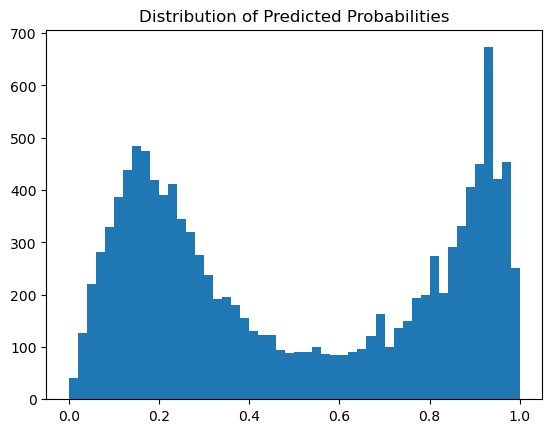

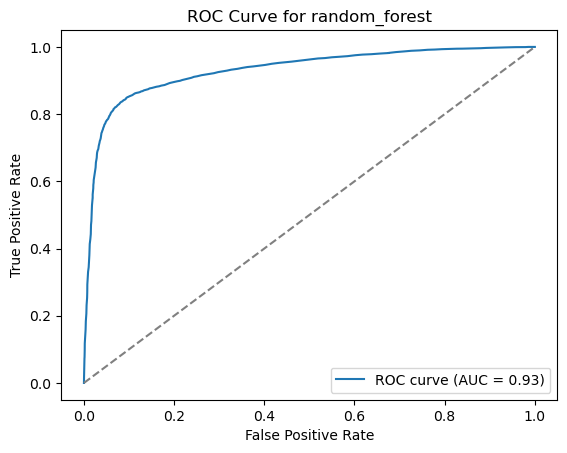

ROC curve saved as 'random_forest_roc_curve.png'
Metrics for random_forest saved as 'random_forest_metrics.csv'
({'accuracy': 0.8768333333333334, 'precision': 0.9098984771573604, 'recall': 0.8365, 'f1': 0.8716568252865579, 'roc_auc': 0.930099}, array([1, 0, 1, ..., 0, 1, 0]), array([0.86 , 0.345, 0.84 , ..., 0.41 , 0.95 , 0.14 ]))


In [266]:
# Display the best parameters and score
print("Best Parameters:", best_rf_params)
rf_metrics = evaluate_model(best_rf_model, X_test['Sequence'].values, y_test, 'random_forest')
print(rf_metrics)

# The SVM model takes to long to train with k-mer size of 10, we will use SVD to reduce the dimensionality of k-mer size of 10 vectors

In [267]:
svd_pipeline = Pipeline([
    ('kmer', KmerVectorizer(K=10)),
    ('scaler', StandardScaler(with_mean=False)),
    ('svd', TruncatedSVD(n_components=10))
])
full_data_reduced = svd_pipeline.fit_transform(combined_data['Sequence'].values)
reduced_X_train, reduced_X_test, reduced_y_train, reduced_y_test = train_test_split(
    full_data_reduced, label_vector, test_size=0.2, stratify=label_vector, random_state=42
)
reduced_X_train, reduced_X_val, reduced_y_train, reduced_y_val = train_test_split(reduced_X_train, reduced_y_train, test_size=0.125, stratify=reduced_y_train, random_state=42)


In [268]:
# training SVM model
from sklearn.svm import SVC
model = SVC(probability=True)
param_grid = {
    'model__C': [0.1, 1, 10],
    'model__gamma': ['scale', 'auto'],
    'model__kernel': ['linear', 'rbf'],
}

best_svm_model, best_svm_params, best_svm_score = gridsearch_with_logging(
    X_train=reduced_X_train,
    y_train=reduced_y_train,
    model=model,
    param_grid=param_grid,
    model_name='svm',
    cv=5,
    scoring='accuracy',
    transform=False
)


Starting grid search for svm with up to 70% CPU usage...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 4/5] END model__C=0.1, model__gamma=scale, model__kernel=rbf;, score=(train=0.856, test=0.850) total time= 2.7min
[CV 1/5] END model__C=1, model__gamma=scale, model__kernel=rbf;, score=(train=0.860, test=0.859) total time= 2.8min
[CV 4/5] END model__C=1, model__gamma=scale, model__kernel=rbf;, score=(train=0.861, test=0.854) total time= 3.2min
[CV 2/5] END model__C=1, model__gamma=scale, model__kernel=rbf;, score=(train=0.860, test=0.858) total time= 3.2min
[CV 3/5] END model__C=1, model__gamma=scale, model__kernel=rbf;, score=(train=0.860, test=0.857) total time= 3.4min
[CV 5/5] END model__C=0.1, model__gamma=scale, model__kernel=rbf;, score=(train=0.854, test=0.855) total time= 3.6min
[CV 3/5] END model__C=0.1, model__gamma=scale, model__kernel=rbf;, score=(train=0.855, test=0.855) total time= 3.8min
[CV 1/5] END model__C=0.1, model__gamma=scale, model__kernel=rbf

Best Parameters: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Evaluating svm on test data...
Results for svm:
Accuracy: 0.86
Precision: 0.90
Recall: 0.81
F1 Score: 0.86
(array([0., 1.]), array([6000, 6000]))
(array([0, 1]), array([6566, 5434]))


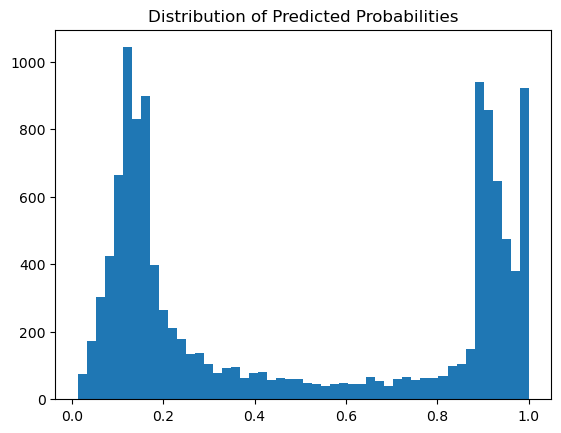

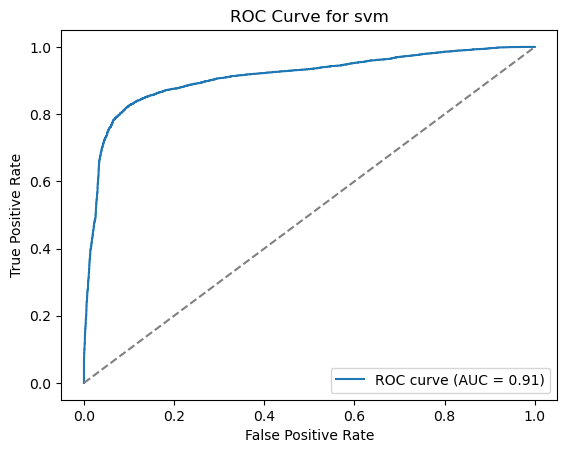

ROC curve saved as 'svm_roc_curve.png'
Metrics for svm saved as 'svm_metrics.csv'
({'accuracy': 0.8621666666666666, 'precision': 0.8998895841001104, 'recall': 0.815, 'f1': 0.8553437117369249, 'roc_auc': 0.9103302222222222}, array([1, 0, 1, ..., 0, 1, 0]), array([0.99129351, 0.1417973 , 0.99324744, ..., 0.1631909 , 0.96520004,
       0.16283546]))


In [270]:
print("Best Parameters:", best_svm_params)
svm_metrics = evaluate_model(best_svm_model, reduced_X_test, reduced_y_test, 'svm')
print(svm_metrics)

In [189]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Lambda
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint



def create_kmer_model_with_transform(X_train_sequences, k=4, hidden_nodes=256, dropout_rate=0.2):
    # Convert the sequences to tf.string tensors
    X_train_sequences = tf.constant(X_train_sequences, dtype=tf.string)

    text_vectorization = TextVectorization(
        standardize=None,
        split='character',
        ngrams=k,
        output_mode='count',
    )
    # Adapt the layer using a tf.data.Dataset
    text_vectorization.adapt(tf.data.Dataset.from_tensor_slices(X_train_sequences).batch(32))

    # Build the model
    model = Sequential([
        text_vectorization,
        Lambda(lambda x: tf.cast(x, tf.float32)),  # Cast counts to float32
        Dense(hidden_nodes, activation='relu'),
        Dropout(dropout_rate),
        Dense(hidden_nodes // 2, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model





In [272]:
y_train_tensor = tf.constant(y_train)
y_val_tensor = tf.constant(y_val)
train_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X_train['Sequence'].values, dtype=tf.string),y_train_tensor)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X_val['Sequence'].values, dtype=tf.string), y_val_tensor)).batch(32)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)


Creating Kmer models for various K values

In [273]:


k_values = [4, 6, 8, 10]
kmer_models = []
kmer_model_names = []

for k in k_values:
    model_name = f'k_{k}'
    print(f"Training model {model_name}...")
    model = create_kmer_model_with_transform(X_train['Sequence'].values, k=k, hidden_nodes=256, dropout_rate=0.2)
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    )
    model_checkpoint = ModelCheckpoint(
        filepath=f'{model_name}_best_model.keras',
        monitor='val_loss',
        save_best_only=True
    )
    model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=[early_stopping, lr_scheduler, model_checkpoint]
    )
    print(f"Model saved as '{model_name}_best_model.h5'")
    kmer_models.append(model)
    kmer_model_names.append(model_name)


Training model k_4...
Epoch 1/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.8217 - loss: 0.5294 - val_accuracy: 0.8733 - val_loss: 0.3163 - learning_rate: 0.0010
Epoch 2/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8752 - loss: 0.3257 - val_accuracy: 0.8803 - val_loss: 0.3122 - learning_rate: 0.0010
Epoch 3/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8841 - loss: 0.3060 - val_accuracy: 0.8747 - val_loss: 0.3179 - learning_rate: 0.0010
Epoch 4/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8834 - loss: 0.3024 - val_accuracy: 0.8833 - val_loss: 0.3014 - learning_rate: 0.0010
Epoch 5/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8880 - loss: 0.2942 - val_accuracy: 0.8832 - val_loss: 0.3086 - learning_rate: 0.0010
Epoch 6/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8872 - loss: 0.2902 - val_accuracy: 0.8837 - val_loss: 0.2973 - learning_rate: 0.0010
Epoch 7/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 

2024-11-30 19:52:05.071978: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1313/1313 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.8498 - loss: 0.3848 - val_accuracy: 0.8868 - val_loss: 0.2851 - learning_rate: 0.0010
Epoch 2/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.8917 - loss: 0.2784 - val_accuracy: 0.8922 - val_loss: 0.2871 - learning_rate: 0.0010
Epoch 3/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.9029 - loss: 0.2506 - val_accuracy: 0.8945 - val_loss: 0.2811 - learning_rate: 0.0010
Epoch 4/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.9100 - loss: 0.2270 - val_accuracy: 0.8955 - val_loss: 0.2801 - learning_rate: 0.0010
Epoch 5/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.9169 - loss: 0.2124 - val_accuracy: 0.8872 - val_loss: 0.3171 - learning_rate: 0.0010
Epoch 6/20
1311/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9251 - loss: 0.1911
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.9251 - 

Evaluating model k_4...
Evaluating k_4_kmer_nn on test data...
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
Results for k_4_kmer_nn:
Accuracy: 0.90
Precision: 0.93
Recall: 0.86
F1 Score: 0.89
(array([0., 1.]), array([6000, 6000]))
(array([0, 1]), array([6455, 5545]))


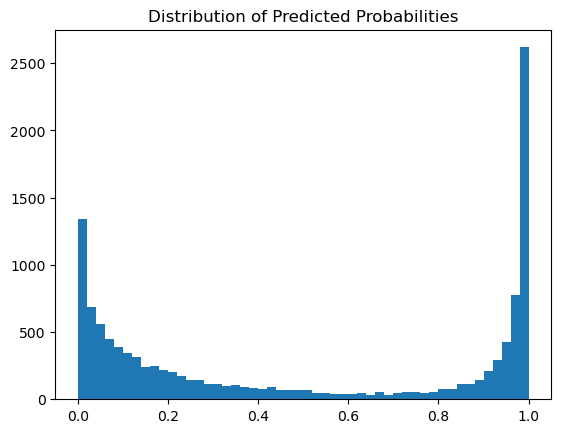

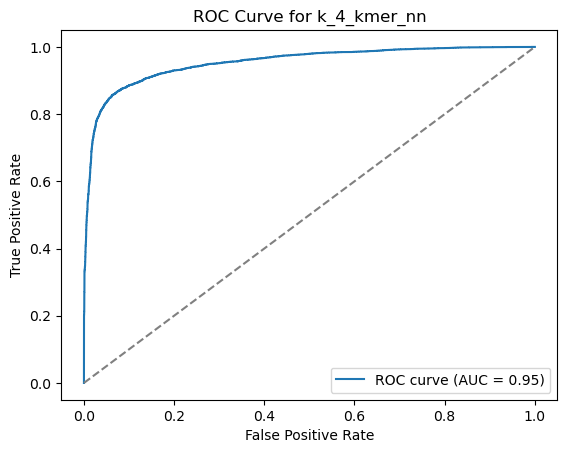

ROC curve saved as 'k_4_kmer_nn_roc_curve.png'
Metrics for k_4_kmer_nn saved as 'k_4_kmer_nn_metrics.csv'
({'accuracy': 0.8964166666666666, 'precision': 0.9289449954914337, 'recall': 0.8585, 'f1': 0.892334343871806, 'roc_auc': 0.9529276944444444}, array([1, 0, 1, ..., 0, 1, 0]), array([0.9494043 , 0.07362311, 0.98926151, ..., 0.00463739, 0.99674606,
       0.0220902 ]))
Evaluating model k_6...
Evaluating k_6_kmer_nn on test data...
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
Results for k_6_kmer_nn:
Accuracy: 0.90
Precision: 0.92
Recall: 0.87
F1 Score: 0.89
(array([0., 1.]), array([6000, 6000]))
(array([0, 1]), array([6364, 5636]))


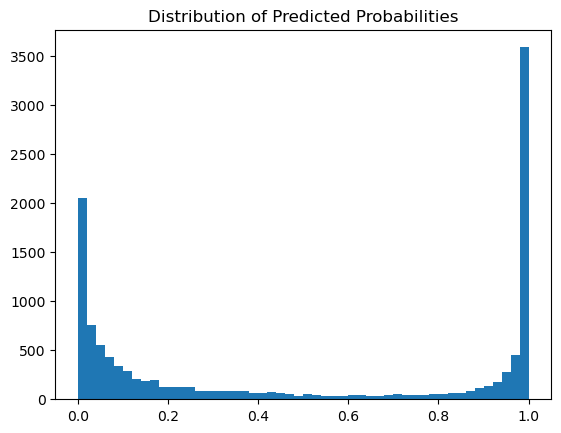

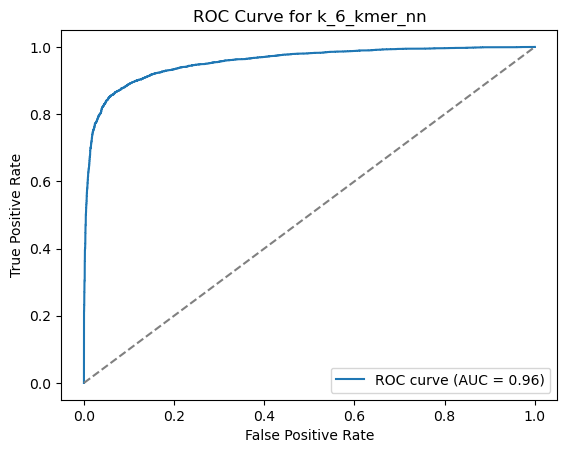

ROC curve saved as 'k_6_kmer_nn_roc_curve.png'
Metrics for k_6_kmer_nn saved as 'k_6_kmer_nn_metrics.csv'
({'accuracy': 0.897, 'precision': 0.9226401703335699, 'recall': 0.8666666666666667, 'f1': 0.8937779305603301, 'roc_auc': 0.95612325}, array([1, 0, 1, ..., 0, 1, 0]), array([0.99374467, 0.15601198, 0.99784029, ..., 0.00984839, 0.99906796,
       0.00542942]))
Evaluating model k_8...
Evaluating k_8_kmer_nn on test data...
115/375 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step

KeyboardInterrupt: 

In [359]:
# evaluating the models
kmer_nn_metrics = {}
for model, name in zip(kmer_models, kmer_model_names):
    print(f"Evaluating model {name}...")
    kmer_nn_metrics[name] = evaluate_model(model, X_test['Sequence'].values, y_test, f'{name}_kmer_nn')
    print(kmer_nn_metrics[name])


<Axes: xlabel='Promoter', ylabel='Length'>

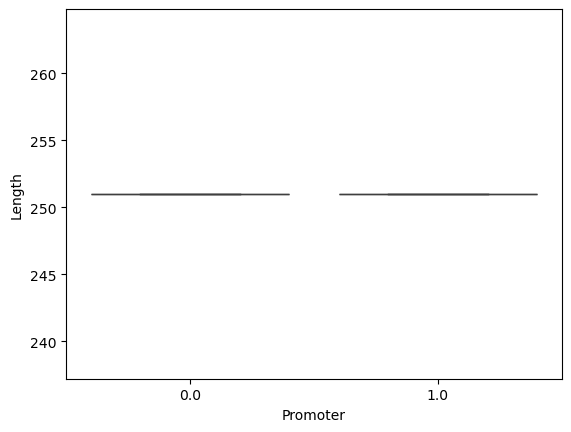

In [275]:
# get lengtyhs of the sequences
lengths_with_labels = pd.DataFrame({'Length': X_train['Sequence'].str.len(), 'Promoter': y_train})
sns.boxplot(data=lengths_with_labels, x='Promoter', y='Length')

# Implementing a Attention based embedding model

In [171]:
from tensorflow.keras.layers import (
    Embedding, GlobalMaxPooling1D, Attention, Input, LSTM, Bidirectional, Dense, MultiHeadAttention, LayerNormalization, Dropout, Conv1D, MaxPooling1D
)
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import keras_hub


# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)
model_checkpoint = ModelCheckpoint(
    filepath='best_model_attention.keras',
    monitor='val_loss',
    save_best_only=True
)

def tokenize_kmers(sequences, k):
    """Tokenize DNA sequences into k-mers."""
    kmers_list = []
    for seq in sequences:
        kmers = [seq[i:i+k] for i in range(len(seq) - k + 1)]
        kmers_list.append(kmers)
    return kmers_list

def build_kmer_tokenizer(sequences, k):
    """Fit a tokenizer on k-mer sequences."""
    kmers = tokenize_kmers(sequences, k)
    flat_kmers = [' '.join(kmer_seq) for kmer_seq in kmers]  # Flatten into space-separated strings
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(flat_kmers)
    return tokenizer

def tokenize_and_pad_kmers(sequences, tokenizer, k, max_length):
    """Convert sequences to k-mers, tokenize them, and pad them."""
    kmers = tokenize_kmers(sequences, k)
    flat_kmers = [' '.join(kmer_seq) for kmer_seq in kmers]
    sequences_tokenized = tokenizer.texts_to_sequences(flat_kmers)
    sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(sequences_tokenized, maxlen=max_length)
    return sequences_padded


def transformer_block(inputs, embed_dim, num_heads, ff_dim, dropout_rate=0.5):
    """Defines a transformer block with multi-head attention and feedforward layers."""
    # setup content and positional bias weights of dimension [num_heads, embed_dim]
    attention_layer = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    attention_output = attention_layer(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)

    # Feedforward Neural Network
    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Dense(embed_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    sequence_output = LayerNormalization(epsilon=1e-6)(ff_output + attention_output)

    return sequence_output





def create_embedding_model_with_transformer(
        max_length, vocab_size, embedding_dim=64,
):
    inputs = Input(shape=(max_length,), dtype=tf.int32)
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
    positional_encoding = keras_hub.layers.SinePositionEncoding(max_wavelength=10000)(embedding)
    embedding = embedding + positional_encoding
    conv = Conv1D(filters=64, kernel_size=10, activation='relu', padding='same')(embedding)
    conv = MaxPooling1D(pool_size=4)(conv)
    # lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
    # attention =MultiHeadAttention(num_heads=8, key_dim=embedding_dim)(lstm, lstm)
    # adding pass through connection
    for i in range(2):
        x = transformer_block(conv, embedding_dim, 8, 256,  dropout_rate=0.5)
    # add passthrough
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    focal_loss = tf.keras.losses.BinaryFocalCrossentropy()
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss=focal_loss, metrics=['accuracy'])
    return model




In [172]:
# Prepare data
max_length = max(len(seq) for seq in X_train['Sequence'])
tokenizer = build_kmer_tokenizer(X_train['Sequence'], k=4)
max_length = max(len(seq) for seq in X_train['Sequence']) - 6
X_train_tokenized = tokenize_and_pad_kmers(X_train['Sequence'], tokenizer, k=4, max_length=max_length)
X_val_tokenized = tokenize_and_pad_kmers(X_val['Sequence'], tokenizer, k=4, max_length=max_length)
vocab_size = len(tokenizer.word_index) + 1
# creating datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tokenized, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tokenized, y_val)).batch(32)

# Create and train the model
attention_model = create_embedding_model_with_transformer(
    max_length=X_train_tokenized.shape[1],
    vocab_size=vocab_size,
    embedding_dim=64,
    lstm_units=256,
)

attention_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
)

TypeError: create_embedding_model_with_transformer() got an unexpected keyword argument 'lstm_units'

Evaluating attention_nn on test data...
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Results for attention_nn:
Accuracy: 0.93
Precision: 0.94
Recall: 0.93
F1 Score: 0.93
(array([0., 1.]), array([6000, 6000]))
(array([0, 1]), array([6082, 5918]))


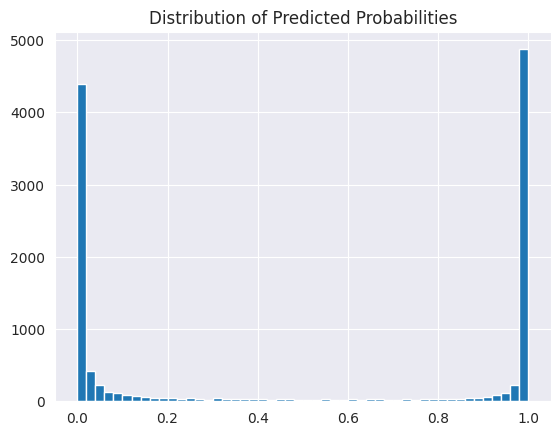

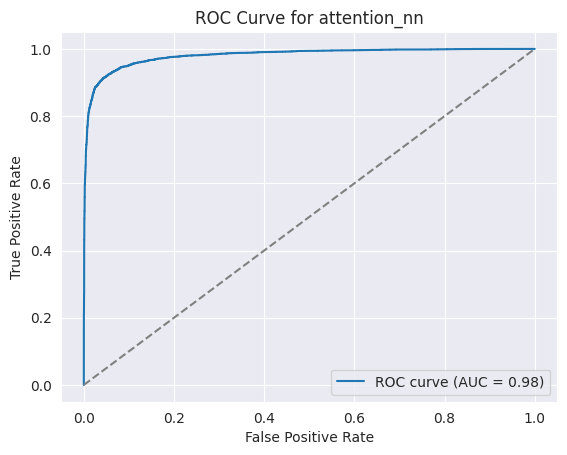

ROC curve saved as 'attention_nn_roc_curve.png'
Metrics for attention_nn saved as 'attention_nn_metrics.csv'
({'accuracy': 0.9336666666666666, 'precision': np.float64(0.9396755660696181), 'recall': np.float64(0.9268333333333333), 'f1': np.float64(0.9332102701795604), 'roc_auc': np.float64(0.9805067638888888)}, array([1, 0, 1, ..., 0, 1, 0]), array([9.99714792e-01, 3.76153475e-04, 9.99774635e-01, ...,
       5.81610687e-02, 9.99989033e-01, 8.35169456e-04]))


In [63]:
# evaluating the model
attention_model.save('best_model_attention.keras')
attention_nn_metrics = evaluate_model(attention_model, X_test['Sequence'], y_test, 'attention_nn', attention=True, max_length=max_length, tokenizer=tokenizer)
print(attention_nn_metrics)

None


In [404]:
# Select a few promoter sequences
from IPython.core.display import display, HTML
promoter_sequences = X_val['Sequence'][:10]

# Tokenize sequences
promoter_sequences_tokenized, = tokenize_dna(promoter_sequences, max_length)
promoter_sequences = promoter_sequences.values
# Get attention weights
attention_weights = attention_vis_model.predict(promoter_sequences_tokenized)

def normalize_weights(weights):
    return weights / np.max(weights, axis=-1, keepdims=True)

# Reduce attention weights to a single value per token
def reduce_attention_weights(attention_weights):
    # Average across the last dimension (shape becomes [batch, sequence length])
    reduced_weights = np.mean(attention_weights, axis=-1)
    return normalize_weights(reduced_weights)

# Normalize attention weights
normalized_attention_weights = reduce_attention_weights(attention_weights)

print(normalized_attention_weights.shape)

def attention_to_html(sequence, weights, tokenizer):
    # Reverse tokenizer to get character mapping
    index_to_char = {v: k for k, v in tokenizer.word_index.items()}
    index_to_char[0] = '-'  # For padding
    index_to_char = {4: 'g', 2: 'c', 3: 't', 1: 'a', 5: 'n', 0: '-'}

    # Decode sequence
    decoded_sequence = [index_to_char[idx] for idx in sequence if idx != 0]

    # Normalize weights
    weights = weights[:len(decoded_sequence)]
    min_weight, max_weight = np.min(weights), np.max(weights)
    weights = (weights - min_weight) / (max_weight - min_weight + 1e-8)

    # Generate HTML with characters styled by weights
    styled_text = ""
    for char, weight in zip(decoded_sequence, weights):
        color = f"rgba(255, 0, 0, {weight})"  # Red with transparency based on weight
        font_weight = int(400 + 300 * weight)  # Scale font weight (400: normal, 700: bold)
        styled_text += f"<span style='color:{color}; font-weight:{font_weight};'>{char}</span>"

    # Display the styled sequence
    display(HTML(f"<div style='font-family: monospace; font-size: 16px;'>{styled_text}</div>"))


# Visualize attention weights for the promoter sequences

for i in range(len(promoter_sequences)):
    print(f"Promoter sequence {i + 1}: {bool(y_val[i])}")
    print(promoter_sequences[i])
    attention_to_html(
        promoter_sequences_tokenized[i],
        normalized_attention_weights[i],
        tokenizer
    )

/tmp/ipykernel_67908/2212212607.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


ValueError: too many values to unpack (expected 1)

#

# Part 3: Do the models generalize to other species

In [123]:
# loading in the data
thaliana = pd.read_csv('Data/ara_tha_final.csv')
mouse = pd.read_csv('Data/mouse_mus_final.csv')
X_mouse = mouse['Sequence']
y_mouse = mouse['Promoter ID']
y_mouse = (y_mouse.str.contains('Non-promoter').astype(int) == 0)
X_thal= thaliana['Sequence']
y_thal = thaliana['Promoter ID']
y_thal = (y_thal.str.contains('Non-promoter').astype(int) == 0)
y_mouse = y_mouse.tail(2052)
X_mouse = X_mouse.tail(2052)
# cutting the sequences to the same length as the training data
X_mouse = X_mouse.str.slice(0, min_len)
x_thal = x_thal.str.slice(0, min_len)


0         True
1         True
2         True
3         True
4         True
         ...  
26341    False
26342    False
26343    False
26344    False
26345    False
Name: Promoter ID, Length: 26346, dtype: bool


Evaluating naive_bayes_mouse on test data...
Results for naive_bayes_mouse:
Accuracy: 0.79
Precision: 0.96
Recall: 0.61
F1 Score: 0.74
(array([False,  True]), array([1026, 1026]))
(array([0, 1]), array([1401,  651]))


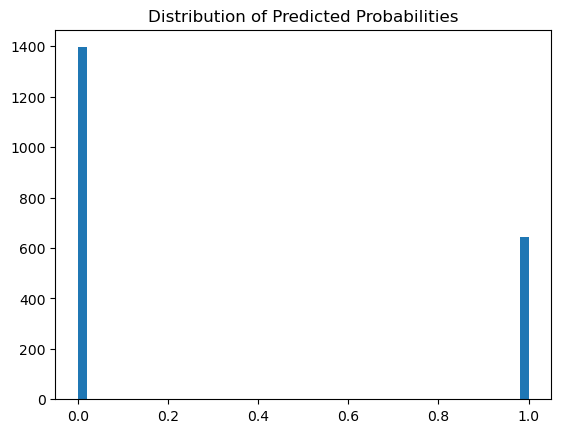

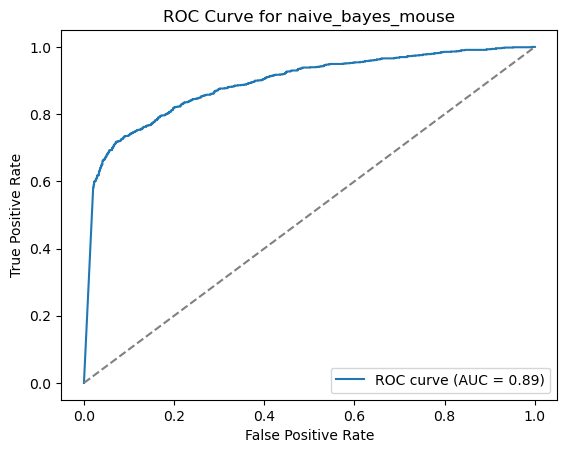

ROC curve saved as 'naive_bayes_mouse_roc_curve.png'
Metrics for naive_bayes_mouse saved as 'naive_bayes_mouse_metrics.csv'


In [330]:
# Transform the data
# predict the mouse data
# evaluate the model
nb_metrics_mouse = evaluate_model(best_nb_model, X_mouse, y_mouse, 'naive_bayes_mouse')

## Evaluating Naive Bayes model on Thaliana data

Evaluating naive_bayes_thaliana on test data...
Results for naive_bayes_thaliana:
Accuracy: 0.50
Precision: 0.51
Recall: 0.07
F1 Score: 0.12
(array([False,  True]), array([3387, 3387]))
(array([0, 1]), array([6339,  435]))


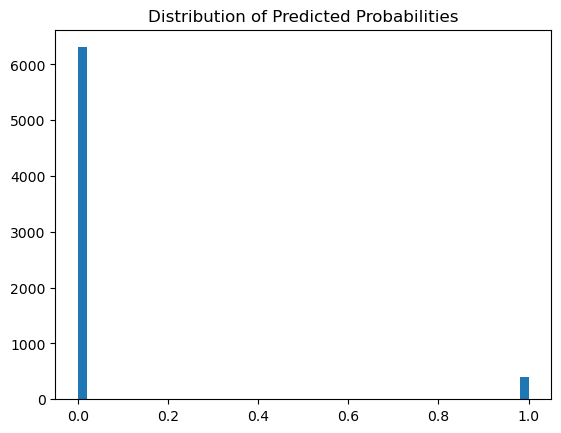

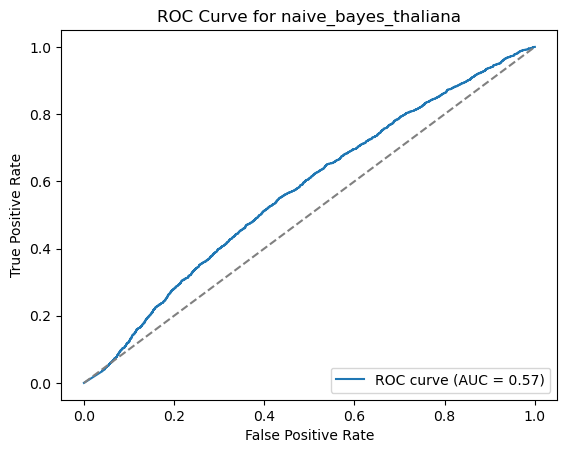

ROC curve saved as 'naive_bayes_thaliana_roc_curve.png'
Metrics for naive_bayes_thaliana saved as 'naive_bayes_thaliana_metrics.csv'


In [307]:
nm_metrics_thal = evaluate_model(best_nb_model, x_thal, y_thal, 'naive_bayes_thaliana')

# Evaluating Random Forest model on mouse data

Evaluating random_forest_mouse on test data...
Results for random_forest_mouse:
Accuracy: 0.79
Precision: 0.95
Recall: 0.61
F1 Score: 0.74
(array([False,  True]), array([1026, 1026]))
(array([0, 1]), array([1400,  652]))


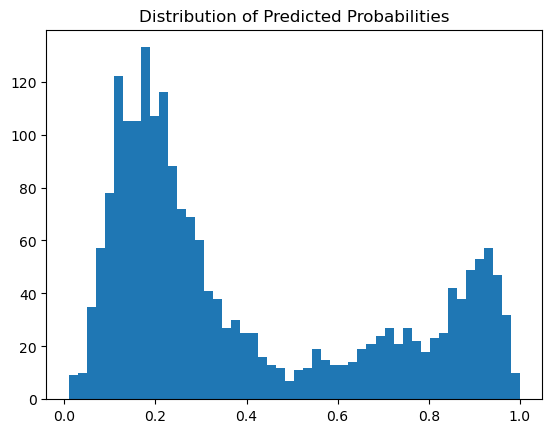

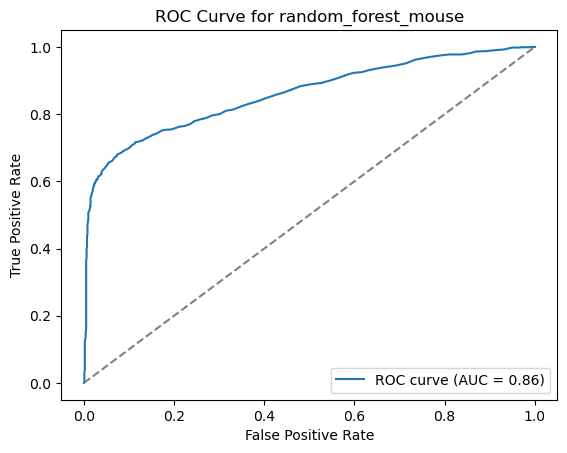

ROC curve saved as 'random_forest_mouse_roc_curve.png'
Metrics for random_forest_mouse saved as 'random_forest_mouse_metrics.csv'


In [308]:
mouse_rf_metrics = evaluate_model(best_rf_model, X_mouse, y_mouse, 'random_forest_mouse')

# Evaluating Random Forest model on Thaliana data

Evaluating random_forest_thaliana on test data...
Results for random_forest_thaliana:
Accuracy: 0.55
Precision: 0.57
Recall: 0.46
F1 Score: 0.51
(array([False,  True]), array([3387, 3387]))
(array([0, 1]), array([4012, 2762]))


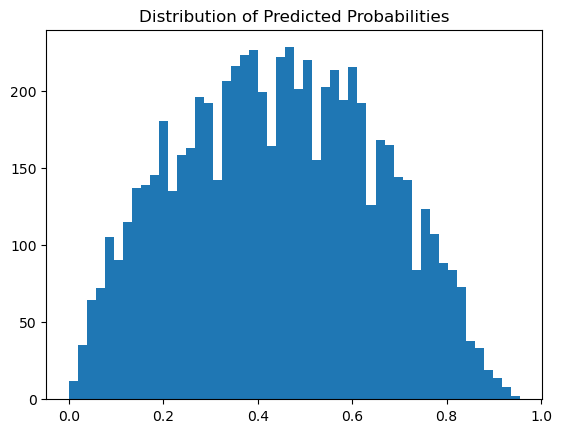

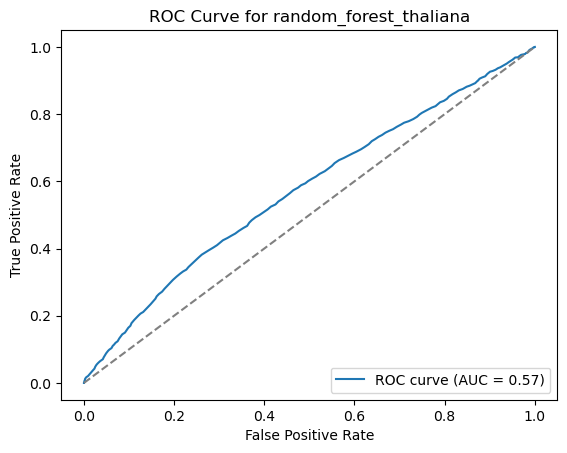

ROC curve saved as 'random_forest_thaliana_roc_curve.png'
Metrics for random_forest_thaliana saved as 'random_forest_thaliana_metrics.csv'


In [309]:
thal_rf_metrics = evaluate_model(best_rf_model, x_thal, y_thal, 'random_forest_thaliana')

Evaluating svm_mouse on test data...
Results for svm_mouse:
Accuracy: 0.77
Precision: 0.95
Recall: 0.58
F1 Score: 0.72
(array([False,  True]), array([1026, 1026]))
(array([0, 1]), array([1426,  626]))


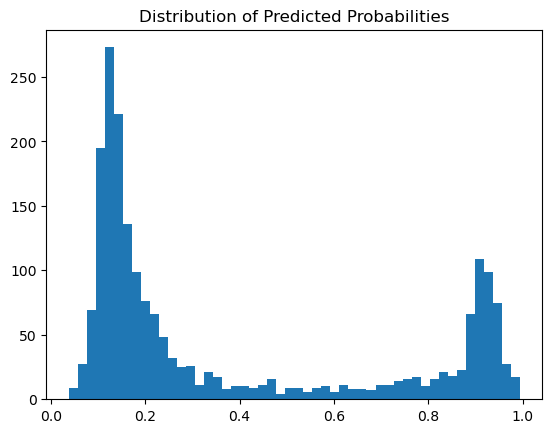

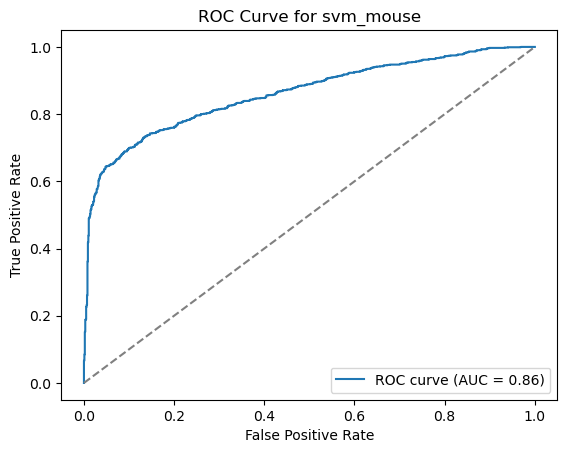

ROC curve saved as 'svm_mouse_roc_curve.png'
Metrics for svm_mouse saved as 'svm_mouse_metrics.csv'


In [310]:
# transforming_mouse_data
mouse_data_reduced = svd_pipeline.transform(X_mouse)
# evaluating the model
svm_metrics_mouse = evaluate_model(best_svm_model, mouse_data_reduced, y_mouse, 'svm_mouse')

{'accuracy': 0.948163388197511, 'precision': 0.9485415934534867, 'recall': 0.9995767643635595, 'f1': 0.9733906906056, 'roc_auc': 0.5196589549916126}


Evaluating svm_thaliana on test data...
Results for svm_thaliana:
Accuracy: 0.57
Precision: 0.63
Recall: 0.34
F1 Score: 0.44
(array([False,  True]), array([3387, 3387]))
(array([0, 1]), array([4951, 1823]))


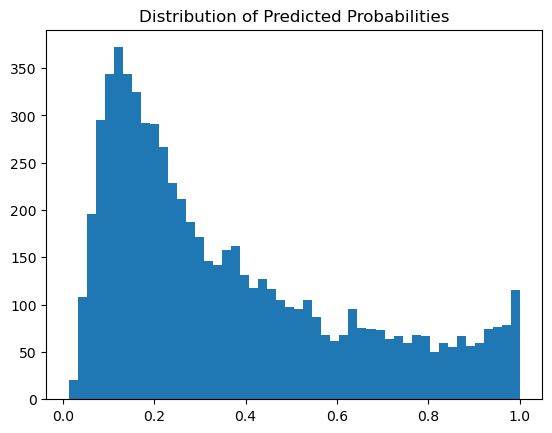

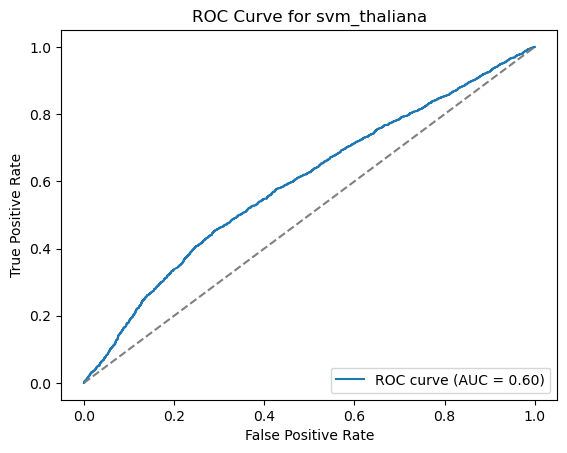

ROC curve saved as 'svm_thaliana_roc_curve.png'
Metrics for svm_thaliana saved as 'svm_thaliana_metrics.csv'


In [311]:
# transforming the thaliana data
thal_data_reduced = svd_pipeline.transform(x_thal)
# evaluating the model
svm_metrics_thal = evaluate_model(best_svm_model, thal_data_reduced, y_thal, 'svm_thaliana')

# evaluating the best Multi-layer perceptron model on mouse data

Evaluating k_10_nn_mouse on test data...
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
Results for k_10_nn_mouse:
Accuracy: 0.81
Precision: 0.89
Recall: 0.71
F1 Score: 0.79
(array([False,  True]), array([1026, 1026]))
(array([0, 1]), array([1239,  813]))


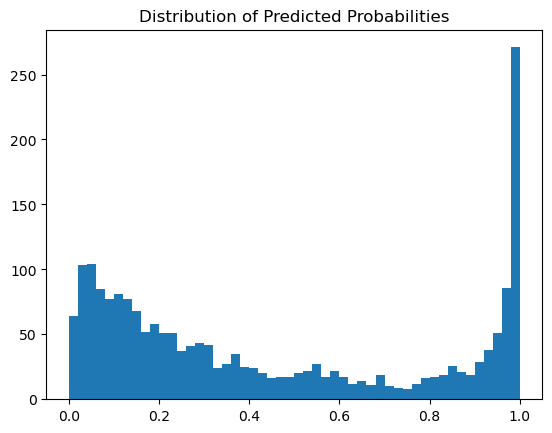

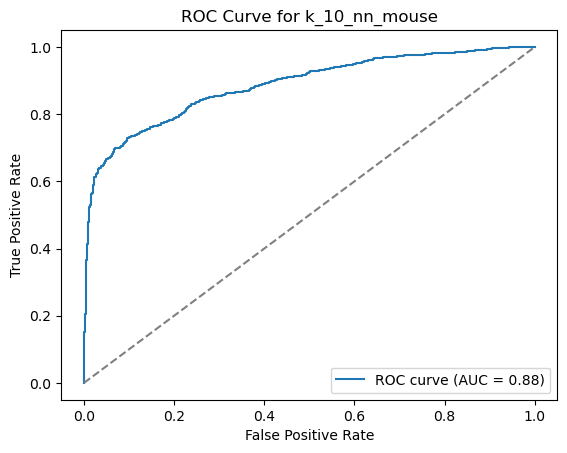

ROC curve saved as 'k_10_nn_mouse_roc_curve.png'
Metrics for k_10_nn_mouse saved as 'k_10_nn_mouse_metrics.csv'


({'accuracy': 0.8104288499025342,
  'precision': 0.8917589175891759,
  'recall': 0.7066276803118908,
  'f1': 0.7884719956498096,
  'roc_auc': 0.8849541549346618},
 array([1, 0, 0, ..., 0, 0, 0]),
 array([0.96049762, 0.2035978 , 0.14129177, ..., 0.26314861, 0.26581079,
        0.11218603]))

In [312]:
# loading the k_6 model
best_k_10_model = kmer_models[-1]
evaluate_model(best_k_6_model, X_mouse, y_mouse, 'k_10_nn_mouse')

## Evaluating the best Multi-layer perceptron model on Thaliana data

Evaluating k_10_nn_thaliana on test data...
212/212 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step
Results for k_10_nn_thaliana:
Accuracy: 0.59
Precision: 0.59
Recall: 0.62
F1 Score: 0.60
(array([False,  True]), array([3387, 3387]))
(array([0, 1]), array([3191, 3583]))


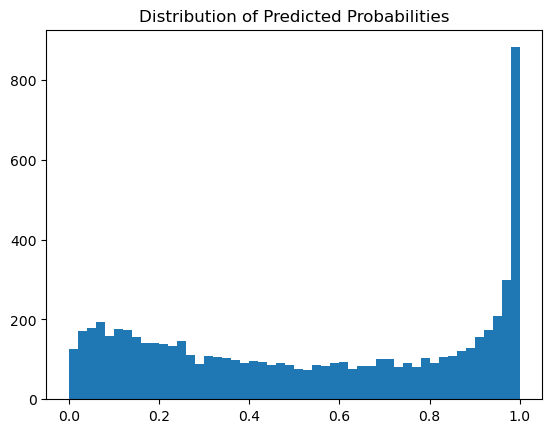

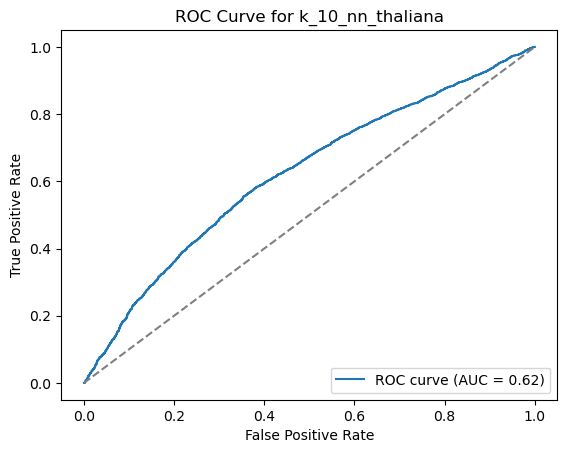

ROC curve saved as 'k_10_nn_thaliana_roc_curve.png'
Metrics for k_10_nn_thaliana saved as 'k_10_nn_thaliana_metrics.csv'


({'accuracy': 0.5934455270150576,
  'precision': 0.588333798492883,
  'recall': 0.6223796870386773,
  'f1': 0.6048780487804878,
  'roc_auc': 0.6209329180181365},
 array([1, 1, 0, ..., 1, 0, 0]),
 array([0.52770615, 0.98906797, 0.3052265 , ..., 0.9915958 , 0.08031086,
        0.25239381]))

In [315]:
evaluate_model(best_k_10_model, x_thal, y_thal, 'k__nn_thaliana')

# Evaluating the attention based model on mouse data

Evaluating attention_nn_mouse on test data...
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Results for attention_nn_mouse:
Accuracy: 0.69
Precision: 0.88
Recall: 0.44
F1 Score: 0.59
(array([False,  True]), array([1026, 1026]))
(array([0, 1]), array([1539,  513]))


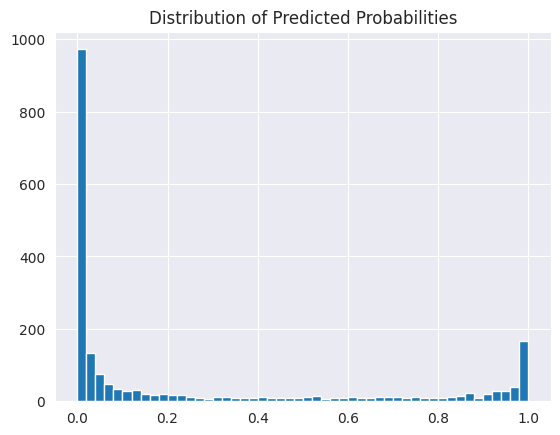

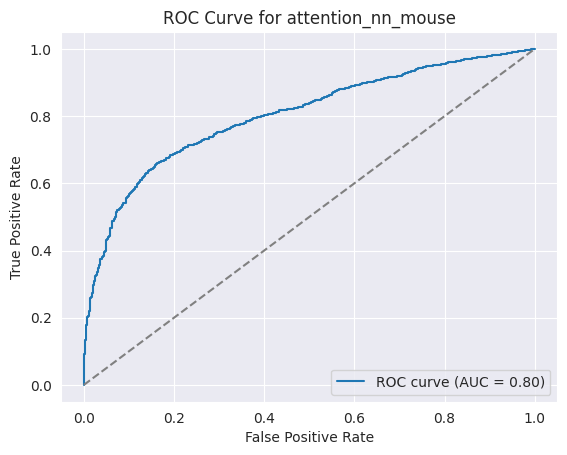

ROC curve saved as 'attention_nn_mouse_roc_curve.png'
Metrics for attention_nn_mouse saved as 'attention_nn_mouse_metrics.csv'


({'accuracy': 0.692495126705653,
  'precision': np.float64(0.884990253411306),
  'recall': np.float64(0.442495126705653),
  'f1': np.float64(0.589993502274204),
  'roc_auc': np.float64(0.8023760397311235)},
 array([1, 0, 0, ..., 0, 1, 0]),
 array([0.9490242 , 0.13637865, 0.00245904, ..., 0.00636016, 0.67408091,
        0.00106469]))

In [64]:
evaluate_model(attention_model, X_mouse, y_mouse, 'attention_nn_mouse', attention=True, max_length=max(X_mouse.str.len())-5, tokenizer=tokenizer)

# Evaluating the attention based model on Thaliana data

Evaluating attention_nn_thaliana on test data...
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Results for attention_nn_thaliana:
Accuracy: 0.56
Precision: 0.58
Recall: 0.42
F1 Score: 0.49
(array([False,  True]), array([3387, 3387]))
(array([0, 1]), array([4312, 2462]))


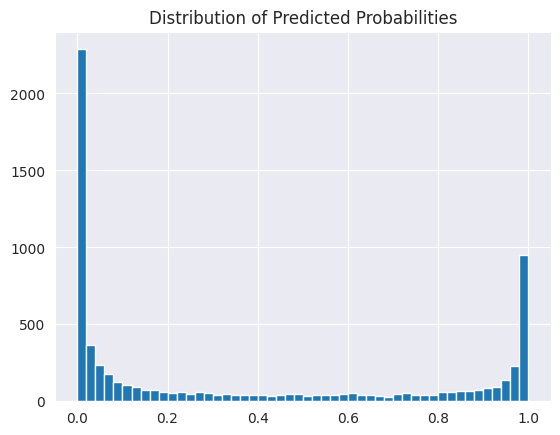

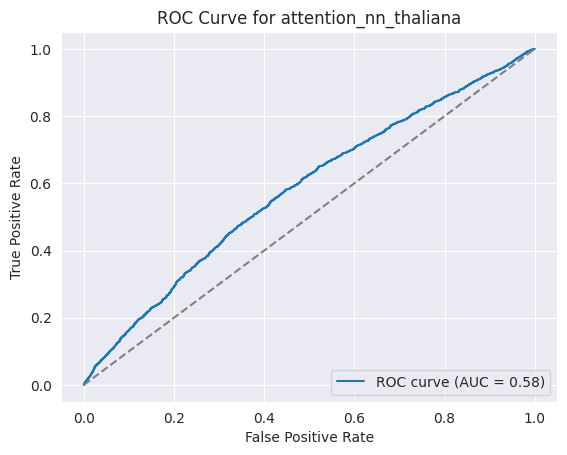

ROC curve saved as 'attention_nn_thaliana_roc_curve.png'
Metrics for attention_nn_thaliana saved as 'attention_nn_thaliana_metrics.csv'


({'accuracy': 0.5587540596397992,
  'precision': np.float64(0.5808285946385053),
  'recall': np.float64(0.42220253912016537),
  'f1': np.float64(0.48897247392716703),
  'roc_auc': np.float64(0.581065832131034)},
 array([0, 0, 0, ..., 1, 0, 0]),
 array([0.00980536, 0.3784079 , 0.02031504, ..., 0.96687692, 0.00445733,
        0.0327103 ]))

In [65]:
evaluate_model(attention_model, x_thal, y_thal, 'attention_nn_thaliana', attention=True, max_length=max(x_thal.str.len())-5, tokenizer=tokenizer)

# The Attention Model fits the training data very well but does not generalize. If we inject a small amount of thaliana data will it generalize better on mouse?

In [107]:
from sklearn.model_selection import train_test_split
hhuman_positive = pd.read_csv('Data/promoter.csv')
human_positive.columns = ['Sequence']
human_negative = pd.read_csv('Data/non_promoter.csv')
human_negative.columns = ['Sequence']
# clip all the sequences to the same length
y_human = np.ones(human_positive.shape[0]).tolist() + np.zeros(human_negative.shape[0]).tolist()
x_human = pd.concat([human_positive, human_negative], axis=0)
min_len = min(x_human['Sequence'].str.len())
# loading in the data
thaliana = pd.read_csv('Data/ara_tha_final.csv')
mouse = pd.read_csv('Data/mouse_mus_final.csv')
x_mouse = mouse[['Sequence']]
y_mouse = mouse['Promoter ID']
y_mouse = (y_mouse.str.contains('Non-promoter').astype(int) == 0)
x_thal = thaliana[['Sequence']]
y_thal = thaliana['Promoter ID']
y_thal = (y_thal.str.contains('Non-promoter').astype(int) == 0).tolist()
x_mouse_negative= x_mouse[~y_mouse]
x_mouse_positive = x_mouse[y_mouse].head(len(x_mouse_negative))
x_mouse = pd.concat([x_mouse_negative, x_mouse_positive], axis=0)
y_mouse = np.zeros(x_mouse_negative.shape[0]).tolist() + np.ones(x_mouse_positive.shape[0]).tolist()
x_mouse= x_mouse['Sequence'].apply(lambda x: x[np.random.randint(0, len(x)-200):np.random.randint(0, len(x)-200)+200])
x_human= x_human['Sequence'].apply(lambda x: x[np.random.randint(0, len(x)-200):np.random.randint(0, len(x)-200)+200])
x_thal= x_thal['Sequence'].apply(lambda x: x[np.random.randint(0, len(x)-200):np.random.randint(0, len(x)-200)+200])
print(x_mouse)
print(x_human)
print(x_thal)
# split human and thal into train, test, and validation
human_x_train, human_x_test, human_y_train, human_y_test  = train_test_split(x_human, y_human, test_size=0.2,)
human_x_train, human_x_val, human_y_train, human_y_val = train_test_split(human_x_train, human_y_train, test_size=0.2)
# split mouse into train, test
mouse_x_train, mouse_x_test, mouse_y_train, mouse_y_test = train_test_split(x_mouse, y_mouse, test_size=0.2)
# split thal and thal into train, test, and validation
thal_x_train, thal_x_test, thal_y_train, thal_y_test = train_test_split(x_thal, y_thal, test_size=0.2)
thal_x_train, thal_x_val, thal_y_train, thal_y_val = train_test_split(thal_x_train, thal_y_train, test_size=0.2)

human_x_train = human_x_train[:len(thal_x_train)+1]
human_y_train = human_y_train[:len(thal_x_train)+1]
# combine human and thal train and validation
cross_x_train = pd.concat([human_x_train, thal_x_train, mouse_x_train], axis=0)
cross_x_val = pd.concat([human_x_val, thal_x_val], axis=0)
cross_y_train = human_y_train + thal_y_train + mouse_y_train
cross_y_val = human_y_val + thal_y_val

18902    AACAAAGGGAAATAAAGGGATACAAAATGGAAAGGAAGAAGAAAAA...
18903    GTGGGCACTCAGACCCTCCAAGACCCTTCCCTGCCTCTCTCCCAAC...
18904    TTCATAGGAAACTCAGCCTGGCACCGTTTTTAAGGACACCAATCTG...
18905    ATGCCATAAATAATATGGTTTGCAACAGTGGGGCAAAATGCACTCG...
18906    GACAGATCGTGGAAACAGAAACTAAACAGGGACACAGTGAAACTAA...
                               ...                        
1021     ACTGCACAAAGCGCCATTCAACTAGAGGCTCCTCTGAGCTCACCTG...
1022     GAAACAAGAGACTTAAAAACAACATCCTATTCTGACTTTATGCAGT...
1023     CTCTAAGGGGTTGATGCTCTTGTTCGAGTCACATAAGTCACCCAGG...
1024     ATTCCTCTTTGTTCCCTTCGCATTTGTCAGCGCGATCAAGTCAGGC...
1025     TTCCAATTCAGCAGATTTTTTTTTCCTCAGTGAAACACAGCATAAT...
Name: Sequence, Length: 2052, dtype: object
0        GTAGGGAGGGCACGAACAGAAAGGTGCTGCGCATGCGTATTGAAAA...
1        TTTTTATTCCCCTCACACTGGGCTTTTAGTAAGCTCCATGAGGTCA...
2        AAGAATTAGAGATGTAACCCAAAGGTCACTATTTTTCTGAGATAAG...
3        AAAGGGCTGCATGGATGCAAGAGACAGGGTGAGTTAAAGTTTAACT...
4        CTTAGAGGAGCTGTTTCCTGCCGGAACTAATTATCTCGACTTGTAG...
            

In [178]:
max_length = max(len(seq) for seq in cross_x_train)
tokenizer = build_kmer_tokenizer(cross_x_train, k=5)
max_length = max(len(seq) for seq in cross_x_train) - 6
X_train_tokenized = tokenize_and_pad_kmers(cross_x_train, tokenizer, k=5, max_length=max_length)
X_val_tokenized = tokenize_and_pad_kmers(cross_x_val, tokenizer, k=5, max_length=max_length)
vocab_size = len(tokenizer.word_index) + 1
# creating datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tokenized, cross_y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tokenized, cross_y_val)).batch(32)

In [186]:
def create_optimized_model(max_length, vocab_size, embedding_dim=128):
    inputs = Input(shape=(max_length,), dtype=tf.int32)

    # Embedding Layer with Position Encoding
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
    positional_encoding = keras_hub.layers.SinePositionEncoding(max_wavelength=10000)(embedding)
    embedding = embedding + positional_encoding

    # Local Feature Extraction via CNN
    conv = Conv1D(filters=128, kernel_size=10, activation='relu', padding='same')(embedding)
    conv = MaxPooling1D(pool_size=2)(conv)



    # Transformer Blocks
    for _ in range(4):
        x = transformer_block(conv, embed_dim=embedding_dim, num_heads=8, ff_dim=256, dropout_rate=0.3)

    # Global Feature Pooling
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)

    # Fully Connected Layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output Layer
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    return model

In [187]:


# Create and train the model
attention_model = create_optimized_model(
    max_length=X_train_tokenized.shape[1],
    vocab_size=vocab_size,
    embedding_dim=128,
)

attention_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
)



Epoch 1/30
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 73s 61ms/step - accuracy: 0.4977 - auc_6: 0.4997 - loss: 0.7067 - val_accuracy: 0.5043 - val_auc_6: 0.5000 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 2/30
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 67s 61ms/step - accuracy: 0.5057 - auc_6: 0.5044 - loss: 0.6939 - val_accuracy: 0.5043 - val_auc_6: 0.5000 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 3/30
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 66s 60ms/step - accuracy: 0.5636 - auc_6: 0.6016 - loss: 0.6592 - val_accuracy: 0.8118 - val_auc_6: 0.8862 - val_loss: 0.4514 - learning_rate: 1.0000e-04
Epoch 4/30
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 68s 61ms/step - accuracy: 0.8274 - auc_6: 0.8873 - loss: 0.4180 - val_accuracy: 0.8304 - val_auc_6: 0.8967 - val_loss: 0.4396 - learning_rate: 1.0000e-04
Epoch 5/30
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 68s 61ms/step - accuracy: 0.8410 - auc_6: 0.9000 - loss: 0.3936 - val_accuracy: 0.8104 - val_auc_6: 0.8965 - val_loss: 0.4645 - learning_rate: 1.0000e-04
Epoch 6/30
1106/1106

KeyboardInterrupt: 

Evaluating human_on_cross_attention on test data...
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Results for human_on_cross_attention:
Accuracy: 0.85
Precision: 0.87
Recall: 0.83
F1 Score: 0.85
(array([0., 1.]), array([5995, 6005]))
(array([0, 1]), array([6245, 5755]))


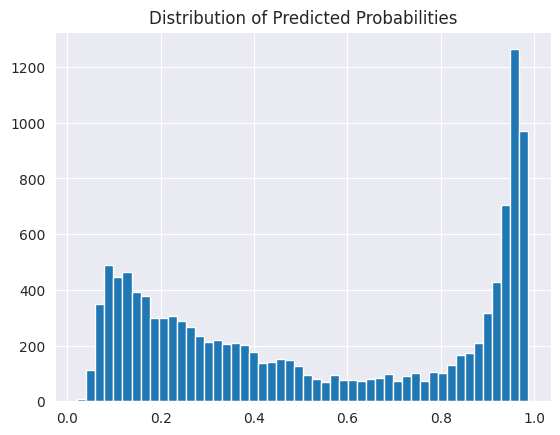

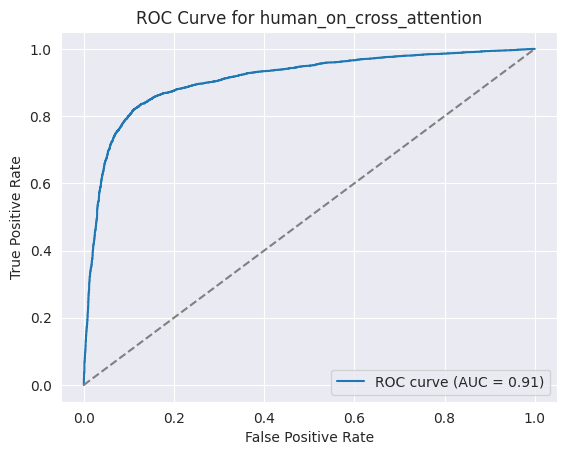

ROC curve saved as 'human_on_cross_attention_roc_curve.png'
Metrics for human_on_cross_attention saved as 'human_on_cross_attention_metrics.csv'


In [181]:
human_on_cross_metrics = evaluate_model(attention_model,human_x_test,human_y_test,'human_on_cross_attention',True, max_length, tokenizer)

Evaluating thal_on_cross_attention on test data...
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Results for thal_on_cross_attention:
Accuracy: 0.76
Precision: 0.73
Recall: 0.82
F1 Score: 0.77
(array([False,  True]), array([2634, 2636]))
(array([0, 1]), array([2320, 2950]))


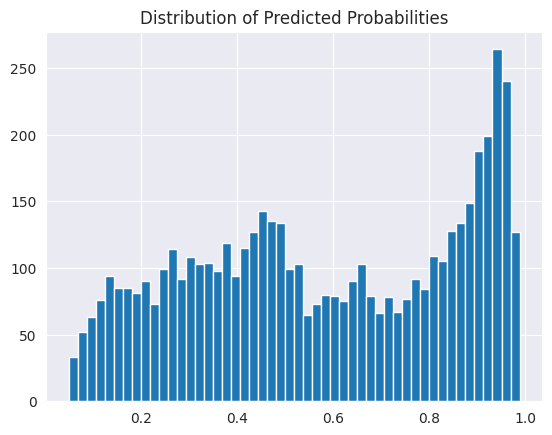

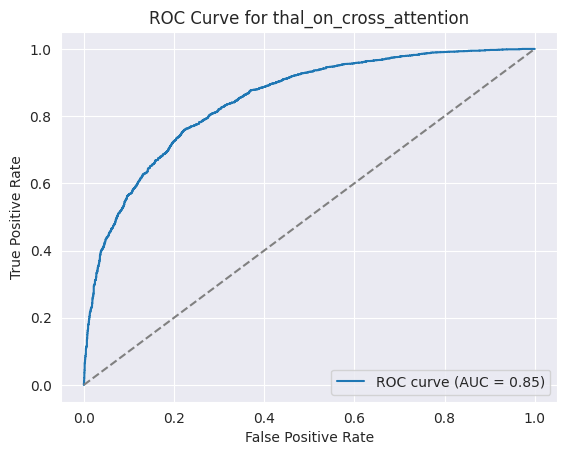

ROC curve saved as 'thal_on_cross_attention_roc_curve.png'
Metrics for thal_on_cross_attention saved as 'thal_on_cross_attention_metrics.csv'


In [182]:
mouse_on_cross_metrics = evaluate_model(attention_model, thal_x_test, thal_y_test,'thal_on_cross_attention',True, max_length, tokenizer)

Evaluating mouse_on_cross on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step
Results for mouse_on_cross:
Accuracy: 0.79
Precision: 0.86
Recall: 0.70
F1 Score: 0.77
(array([0., 1.]), array([204, 207]))
(array([0, 1]), array([244, 167]))


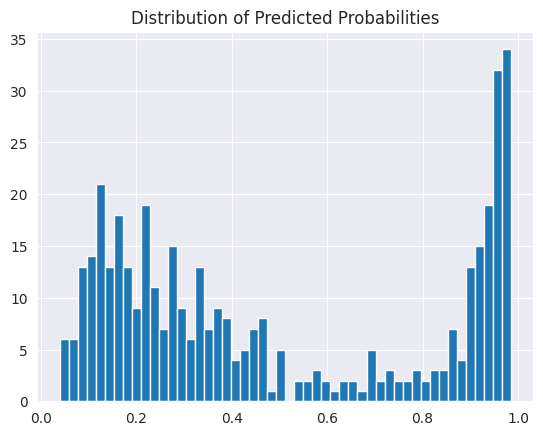

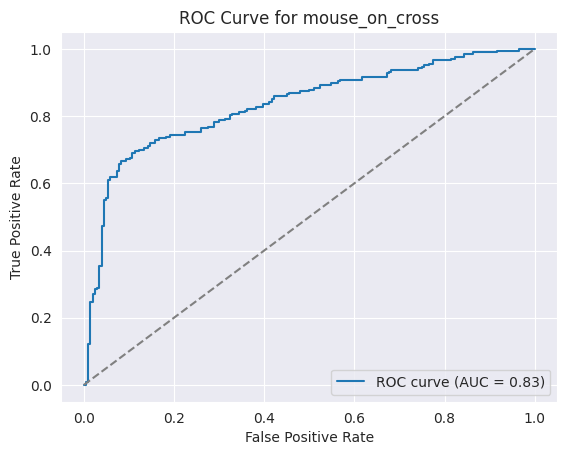

ROC curve saved as 'mouse_on_cross_roc_curve.png'
Metrics for mouse_on_cross saved as 'mouse_on_cross_metrics.csv'


({'accuracy': 0.7907542579075426,
  'precision': np.float64(0.8622754491017964),
  'recall': np.float64(0.6956521739130435),
  'f1': np.float64(0.7700534759358288),
  'roc_auc': np.float64(0.833901676612674)},
 array([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 

In [183]:
evaluate_model(attention_model, mouse_x_test, mouse_y_test,'mouse_on_cross',True, max_length, tokenizer)

In [192]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(cross_x_train, dtype=tf.string),y_train_tensor)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(cross_x_train, dtype=tf.string), y_val_tensor)).batch(32)

model = create_kmer_model_with_transform(cross_x_train,8,256,.5)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)
model_checkpoint = ModelCheckpoint(
    filepath=f'cross_k8_best_model.keras',
    monitor='val_loss',
    save_best_only=True
)
model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)


Epoch 1/20


ValueError: Exception encountered when calling TextVectorization.call().

[1mWhen using `TextVectorization` to tokenize strings, the input rank must be 1 or the last shape dimension must be 1. Received: inputs.shape=(None, 344) with rank=2[0m

Arguments received by TextVectorization.call():
  • inputs=tf.Tensor(shape=(None, 344), dtype=string)